# **fGraph 0 detection with Decision Trees and SVM from eigenvalues**


<div id="import_libraries">
    <h2>Import Libraries</h2>
</div>


In [1]:
#!pip install pandas
#!pip install scikit-learn
#!pip install matplotlib
#!pip install xgboost

To import the libraries that will be used in this lab, execute the cells below. 


In [1]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import ast
import time
# model trainin set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
#models 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor
#model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score

## Load the dataset

Execute the cell below to load the dataset to the variable `raw_data`. The code will fetch the data set for the URL and load the same to the variable. A snapshot of the dataset will be generated as an output.


In [4]:
# load the dataset
path= "graph_walks_7.csv"
# read the input data
raw_data = pd.read_csv(path)
# convert Coefficents True and False to 1 and 0
raw_data['COEFFICIENTS'] = (raw_data['COEFFICIENTS']== 0).apply(int)
raw_data

,COEFFICIENTS,DEN_WALKS2,DEN_WALKS3,DEN_WALKS4,DEN_WALKS5,DEN_WALKS6,DEN_WALKS7,DEN_WALKS8,DEN_WALKS9,DEN_WALKS10,...,FGRAPH_WALKS2,FGRAPH_WALKS3,FGRAPH_WALKS4,FGRAPH_WALKS5,FGRAPH_WALKS6,FGRAPH_WALKS7,FGRAPH_WALKS8,FGRAPH_WALKS9,FGRAPH_WALKS10,FGRAPH_WALKS11
0,0,27,54,357,1460,7611,36358,181797,894132,4435867,...,32,93,700,3710,22967,134435,807476,4803411,28702742,171213911
1,1,27,54,357,1460,7611,36358,181797,894132,4435867,...,32,87,712,3630,23147,133602,809504,4795305,28722712,171133182
2,0,27,54,357,1460,7611,36358,181797,894132,4435867,...,32,93,708,3695,23039,133945,806460,4786356,28614547,170538346
3,0,27,54,357,1460,7611,36358,181797,894132,4435867,...,32,87,716,3615,23159,133161,807788,4779420,28627687,170479188
4,0,27,54,357,1460,7611,36358,181797,894132,4435867,...,32,93,696,3730,22943,134904,808864,4818513,28787292,171815754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,1,25,42,301,1065,5500,23877,114305,523230,2458065,...,27,60,439,1865,10617,52563,281667,1449987,7636507,39738567
216,1,26,48,370,1380,7682,34804,178306,855660,4273826,...,28,72,516,2460,14104,75600,418532,2290356,12605608,69236904
217,1,24,36,268,860,4356,17640,81300,352656,1586964,...,25,45,333,1220,6472,28777,141625,664173,3206495,15266174
218,1,25,42,315,1035,5551,22743,110847,490704,2316320,...,28,72,504,2360,13264,70112,382496,2067552,11238208,61003008


## Study correlation matrix

<Axes: >

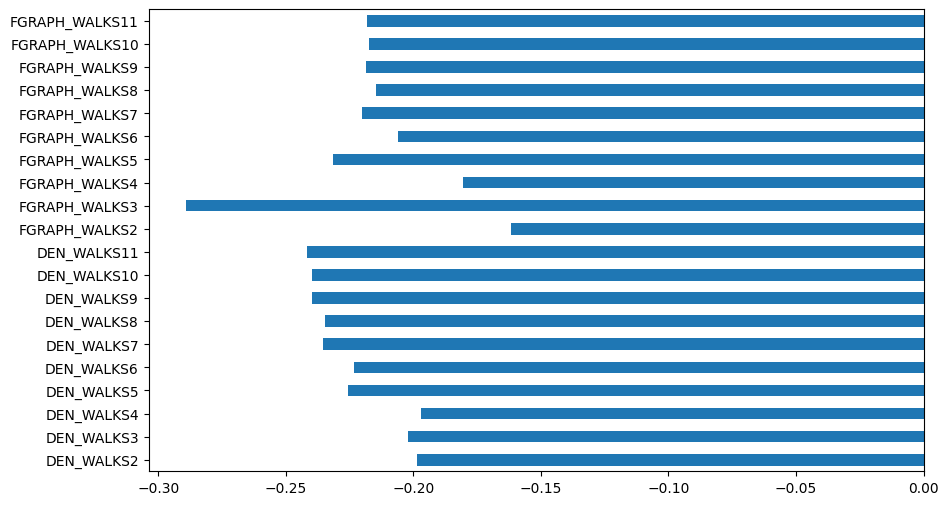

In [3]:
correlation_values = raw_data.corr()['COEFFICIENTS'].drop('COEFFICIENTS')
correlation_values.plot(kind='barh', figsize=(10, 6))

<div id="dataset_preprocessing">
    <h2>Dataset Preprocessing</h2>
</div>


Prepare the data for training. Apply standard scaling to the input features and normalize them using $L_1$ norm for the training models to converge quickly. COEFFICIENTS will be used as the target variable.


In [5]:
#Number of columns
col_num = len(raw_data.columns)
col_num

21

In [8]:
# standardize features by removing the mean and scaling to unit variance
raw_data.iloc[:, 1:col_num] = StandardScaler().fit_transform(raw_data.iloc[:, 1:col_num])
data_matrix = raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:col_num]

# y: labels vector
y = data_matrix[:, 0]

# data normalization
X = normalize(X, norm="l1")

<div id="dataset_split">
    <h2>Dataset Train/Test Split</h2>
</div>


Divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<div id="dt_sklearn">
    <h2>Build a Decision Tree Classifier model with Scikit-Learn</h2>
</div>


Compute the sample weights to be used as input to the train routine so that it takes into account the class imbalance present in this dataset.


In [10]:
w_train = compute_sample_weight('balanced', y_train)

Using these sample weights, we may train the Decision Tree classifier. We also make note of the time it takes for training this model to compare it against SVM, later in the lab.


In [11]:
# for reproducible output across multiple function calls, set random_state to a given integer value
# Best depth is 5
dt = DecisionTreeClassifier(max_depth=5, random_state=35)

dt.fit(X_train, y_train, sample_weight=w_train)

DecisionTreeClassifier(max_depth=5, random_state=35)

<div id="svm_sklearn">
    <h2>Build a Support Vector Machine model with Scikit-Learn</h2>
</div>


Unlike Decision Trees, we do not need to initiate a separate sample_weight for SVMs. We can simply pass a parameter in the scikit-learn function.


In [12]:
# for reproducible output across multiple function calls, set random_state to a given integer value
svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

svm.fit(X_train, y_train)

LinearSVC(class_weight='balanced', fit_intercept=False, loss='hinge',
          random_state=31)

<div id="dt_sklearn_snapml">
    <h2>Evaluate the Decision Tree Classifier Models</h2>
</div>


Probabilities of the test coeffciente to be zero

In [13]:
y_pred_dt = dt.predict_proba(X_test)[:,1]

Using these probabilities, we can evaluate the Area Under the Receiver Operating Characteristic Curve (ROC-AUC) score as a metric of model performance. 
The AUC-ROC score evaluates your model's ability to distinguish positive and negative classes considering all possible probability thresholds. The higher its value, the better the model is considered for separating the two classes of values.


In [14]:
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print('Decision Tree ROC-AUC score : {0:.3f}'.format(roc_auc_dt))

Decision Tree ROC-AUC score : 0.778


In [15]:
dt.score(X_test, y_test)

0.8181818181818182

<div id="svm_sklearn_snap">
    <h2>Evaluate the Support Vector Machine Models</h2>
</div>


Run the following cell to compute the probabilities of the test samples belonging to the class of fraudulent transactions. 


In [16]:
y_pred_svm = svm.decision_function(X_test)

You may now evaluate the accuracy of SVM on the test set in terms of the ROC-AUC score.


In [17]:
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
print("SVM ROC-AUC score: {0:.3f}".format(roc_auc_svm))

SVM ROC-AUC score: 0.743


In [18]:
svm.score(X_test, y_test)

0.6136363636363636

## Random Forest and xgBoost

In [19]:
# Initialize models
n_estimators = 100
rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
xgb = XGBRegressor(n_estimators=n_estimators, random_state=42)

In [20]:
# Fit models
# Measure training time for Random Forest
start_time_rf = time.time()
rf.fit(X_train, y_train)
end_time_rf = time.time()
rf_train_time = end_time_rf - start_time_rf

# Measure training time for XGBoost
start_time_xgb = time.time()
xgb.fit(X_train, y_train)
end_time_xgb = time.time()
xgb_train_time = end_time_xgb - start_time_xgb

In [21]:
print(rf_train_time,xgb_train_time)

0.2777400016784668 0.13584113121032715


In [22]:
# Measure prediction time for Random Forest
start_time_rf = time.time()
y_pred_rf = rf.predict(X_test)
rf_pred_time = time.time() - start_time_rf
print(rf_pred_time)

# Measure prediction time for XGBoost
start_time_xgb = time.time()
y_pred_xgb = xgb.predict(X_test)
xgb_pred_time = time.time() - start_time_rf
print(xgb_pred_time)

0.011466264724731445
0.015883445739746094


In [23]:
# accuracy metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_xgb = mean_squared_error(y_test,y_pred_xgb)
r2_rf = r2_score(y_test,y_pred_rf)
r2_xgb = r2_score(y_test,y_pred_xgb)

In [24]:
mse_rf, mse_xgb

(0.14804318181818182, 0.1294818884279185)

In [25]:
r2_rf, r2_xgb

(0.3755738562091504, 0.4538628845393242)

In [26]:
def approximate(num):
    """
    Approximates a number between 0 and 1 to 0 or 1.
    
    Parameters:
    num (float): A number between 0 and 1.
    
    Returns:
    int: 0 if num is less than 0.5, otherwise 1.
    """
    return 0 if num < 0.5 else 1

In [27]:
diff = xgb.predict(X_test)- y_test
[ approximate(i) for i in abs(diff)].count(1) / len(diff) * 100

20.454545454545457

In [28]:
diff = rf.predict(X_test)- y_test
[ approximate(i) for i in abs(diff)].count(1) / len(diff) * 100

18.181818181818183

In [29]:
[ approximate(i) for i in  rf.predict(X_test) - xgb.predict(X_test)].count(1)

0

The two models perform identically and have an error of the 20%

# Improved data set based on correlation

In [43]:

# Define the target column
target = "COEFFICIENTS"

# Compute the correlation of each feature with the target variable
# (this uses Pearson correlation by default)
correlations = raw_data.corr()[target].drop(target)

In [44]:
# Set a threshold for feature selection based on correlation with the target
correlation_threshold = 0.2
selected_features = correlations[correlations.abs() >= correlation_threshold].index.tolist()
print("\nFeatures with absolute correlation >= {}:".format(correlation_threshold))
print(selected_features)


Features with absolute correlation >= 0.2:
['EV_DEN4', 'EV_DEN8', 'EV_DEN9', 'EV_DEN10', 'EV_FGRAPH4', 'EV_FGRAPH5', 'EV_FGRAPH6', 'EV_FGRAPH10']


In [45]:
# Create a correlation matrix for the selected features to check for multicollinearity
corr_matrix = raw_data[selected_features].corr().abs()

# Create an upper triangle matrix of correlations
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features that are highly correlated with any other feature (e.g., correlation > 0.9)
high_corr_threshold = 0.9
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > high_corr_threshold)]
print("\nFeatures to drop due to high inter-correlation (threshold > {}):".format(high_corr_threshold))
print(to_drop)


Features to drop due to high inter-correlation (threshold > 0.9):
['EV_FGRAPH10']


In [46]:
# Final list of features after dropping those with high inter-correlation
final_features = [feature for feature in selected_features if feature not in to_drop]
print("\nFinal selected features for modeling:")
print(final_features)



Final selected features for modeling:
['EV_DEN4', 'EV_DEN8', 'EV_DEN9', 'EV_DEN10', 'EV_FGRAPH4', 'EV_FGRAPH5', 'EV_FGRAPH6']


Train xgBoost on improved dataset

In [47]:
data = raw_data[["COEFFICIENTS"]+final_features]
col_num = len(final_features)+1

In [48]:
# standardize features by removing the mean and scaling to unit variance
data.iloc[:, 1:col_num] = StandardScaler().fit_transform(data.iloc[:, 1:col_num])
data_matrix = raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:col_num]

# y: labels vector
y = data_matrix[:, 0]

# data normalization
X = normalize(X, norm="l1")

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
w_train = compute_sample_weight('balanced', y_train)

In [50]:
# Measure training time for XGBoost
start_time_xgb = time.time()
xgb.fit(X_train, y_train)
end_time_xgb = time.time()
xgb_train_time = end_time_xgb - start_time_xgb

In [51]:
diff = xgb.predict(X_test)- y_test
[ approximate(i) for i in abs(diff)].count(1) / len(diff) * 100

38.63636363636363

# PL regression

In [52]:
from sklearn.cross_decomposition import PLSRegression

In [57]:
# standardize features by removing the mean and scaling to unit variance
raw_data.iloc[:, 1:col_num] = StandardScaler().fit_transform(raw_data.iloc[:, 1:col_num])
data_matrix = raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:col_num]

# y: labels vector
y = data_matrix[:, 0]

In [58]:
# Instantiate a PLS model; here, we try with 1 component
pls = PLSRegression(n_components=1)
pls.fit(X, y)

PLSRegression(n_components=1)

Correlation between the latent variable and the target: 0.27760522309426666
R2 score: 0.07706465988921696


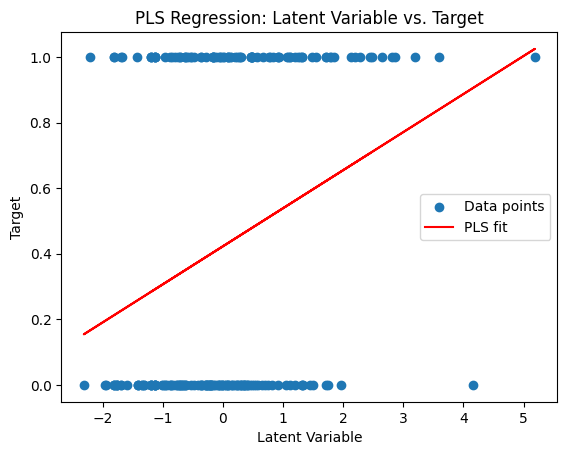

In [59]:
# Transform the original data into the latent space
X_pls = pls.transform(X)

# Calculate the correlation between the latent variable and target
latent_correlation = np.corrcoef(X_pls[:, 0], y)[0, 1]
print("Correlation between the latent variable and the target:", latent_correlation)

# Optionally, assess the model performance
y_pred = pls.predict(X)
print("R2 score:", r2_score(y, y_pred))

# Visualize the relationship
plt.scatter(X_pls, y, label='Data points')
plt.plot(X_pls, y_pred, color='red', label='PLS fit')
plt.xlabel('Latent Variable')
plt.ylabel('Target')
plt.title('PLS Regression: Latent Variable vs. Target')
plt.legend()
plt.show()


In [60]:
pd.join(pd.DataFrame( X_pls)

,0
0,-1.190074
1,-1.190074
2,-1.190074
3,-1.190074
4,-1.190074
...,...
215,0.480849
216,2.288442
217,0.207087
218,3.593497


In [71]:
raw_data.corr()["COEFFICIENTS"]

COEFFICIENTS     1.000000
EV_DEN0         -0.146600
EV_DEN1          0.120308
EV_DEN2          0.063196
EV_DEN3          0.002574
EV_DEN4          0.245492
EV_DEN5          0.050562
EV_DEN6          0.072698
EV_DEN7         -0.160964
EV_DEN8         -0.227509
EV_DEN9          0.452520
EV_DEN10        -0.224613
EV_FGRAPH0      -0.139584
EV_FGRAPH1      -0.169317
EV_FGRAPH2       0.091218
EV_FGRAPH3       0.062660
EV_FGRAPH4       0.317955
EV_FGRAPH5       0.499899
EV_FGRAPH6       0.234445
EV_FGRAPH7       0.117371
EV_FGRAPH8      -0.150855
EV_FGRAPH9      -0.025296
EV_FGRAPH10     -0.241272
EV_DEN_SUM       0.341289
EV_FGRAPH_SUM    0.430049
Name: COEFFICIENTS, dtype: float64